# 🚢 Phase 2: Marine Workability Analysis
## Calculate when you CAN and CANNOT work offshore!

**What you'll learn:**
1. What are "operational limits" and why they matter
2. How to define limits for different operations (crane, diving, etc.)
3. How to calculate workability percentage from scatter diagrams
4. How to compare different vessel types
5. How to find the best months for operations
6. How to create workability reports for project planning

**Prerequisites:** You should have completed Phase 1 (data extraction and scatter diagrams)

---

## Part 1: Setup and Load Previous Results

First, let's load the data we created in Phase 1.

In [1]:
# Import libraries
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

print("✅ Libraries loaded!")

✅ Libraries loaded!


In [2]:
# Load the COMPLETE metocean dataset (waves + wind + currents!)
print("📂 Loading complete metocean dataset...\n")

# Try to load the saved files
try:
    # Time series with currents
    ts_file = Path('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')
    df = pd.read_parquet(ts_file)
    print(f"✅ Complete time series loaded: {len(df):,} records")

    # Scatter diagram
    sc_file = Path('../data/processed/scatter_diagrams/UK_NortheastCoast_2015_2025_scatter.parquet')
    scatter_df = pd.read_parquet(sc_file)
    print(f"✅ Scatter diagram loaded: {len(scatter_df)} cells")

    print(f"\n📊 Data summary:")
    print(f"  Date range: {df['time'].min()} to {df['time'].max()}")
    print(f"  Wave - Mean Hs: {df['hs'].mean():.2f} m, Max Hs: {df['hs'].max():.2f} m")
    print(f"  Wind - Mean: {df['wind_speed'].mean():.2f} m/s, Max: {df['wind_speed'].max():.2f} m/s")

    # Check current data availability
    current_available = df['current_speed_knots_max'].notna().sum()
    current_pct = current_available / len(df) * 100
    if current_available > 0:
        print(f"  Current - Mean max: {df['current_speed_knots_max'].mean():.2f} kt, Absolute max: {df['current_speed_knots_max'].max():.2f} kt")
        print(f"  ⚠️ Current data coverage: {current_pct:.1f}% ({current_available:,} records)")
    else:
        print(f"  ⚠️ No current data available")

except FileNotFoundError:
    print("❌ Data files not found!")
    print("\nPlease run Phase 1 and Phase 1B notebooks first to generate the complete dataset.")
    print("File needed: UK_NortheastCoast_2015_2025_complete.parquet")

📂 Loading complete metocean dataset...

✅ Complete time series loaded: 15,859 records
✅ Scatter diagram loaded: 126 cells

📊 Data summary:
  Date range: 2015-01-01 00:00:00 to 2025-11-08 12:00:00
  Wave - Mean Hs: 1.34 m, Max Hs: 7.65 m
  Wind - Mean: 7.42 m/s, Max: 21.82 m/s
  Current - Mean max: 2.07 kt, Absolute max: 3.99 kt
  ⚠️ Current data coverage: 35.4% (5,611 records)


---
## Part 2: Understanding Operational Limits

**What are operational limits?**
- Maximum wave height you can work in
- Maximum wind speed allowed
- Sometimes: max vessel motion (roll, pitch, heave)

**Why do they exist?**
- Safety (crew, equipment)
- Equipment capability (crane lifting capacity)
- Regulatory requirements (HSE rules)

**Examples:**
- Crane operations: Hs < 2.5m, Wind < 15 m/s
- Diving operations: Hs < 1.5m, Wind < 10 m/s
- Jack-up operations: Hs < 1.0m
- Vessel transfer: Hs < 2.0m

In [4]:
# Let's define some common operational limits (now with CURRENTS!)
print("=" * 80)
print("🚢 TYPICAL OPERATIONAL LIMITS FOR OFFSHORE WORK")
print("=" * 80)

# Dictionary of operations and their limits
operations = {
    'Crane Operations (Heavy Lift)': {
        'max_hs': 2.0,        # meters
        'max_wind': 15.0,     # m/s
        'max_current': 1.5,   # knots (NEW!)
        'description': 'Offshore crane lifting operations (vessels, platforms)'
    },
    'Crane Operations (Light)': {
        'max_hs': 2.0,
        'max_wind': 18.0,
        'max_current': 1.0,
        'description': 'Lighter crane work, less critical lifts'
    },
    'Diving Operations': {
        'max_hs': 1.5,
        'max_wind': 15.0,
        'max_current': 1.0,  # Very sensitive to currents!
        'description': 'Subsea diving, very current-sensitive'
    },
    'Jack-up Operations': {
        'max_hs': 1.5,
        'max_wind': 15.0,
        'max_current': 1.0,
        'description': 'Jack-up barge positioning, leg operations'
    },
    'Vessel Transfer': {
        'max_hs': 2.0,
        'max_wind': 15.0,
        'max_current': 1.5,
        'description': 'Personnel/cargo transfer between vessels'
    },
    'Cable Laying': {
        'max_hs': 2.0,
        'max_wind': 15.0,
        'max_current': 1.0,  # Currents critical for cable tension
        'description': 'Subsea cable installation'
    },
    'ROV Operations': {
        'max_hs': 1.5,
        'max_wind': 15.0,
        'max_current': 1.0,  # ROVs struggle in strong currents
        'description': 'ROV surveys and subsea work'
    },
    'Survey Work': {
        'max_hs': 1.5,
        'max_wind': 20.0,
        'max_current': .5,  # Less current-sensitive
        'description': 'Offshore surveys, measurements'
    }
}

# Display all operations
for op_name, limits in operations.items():
    print(f"\n📋 {op_name}")
    print(f"   Max Hs: {limits['max_hs']} m")
    print(f"   Max Wind: {limits['max_wind']} m/s ({limits['max_wind']*1.94384:.0f} knots)")
    print(f"   Max Current: {limits['max_current']} knots ⚠️ NEW!")
    print(f"   → {limits['description']}")

print("\n💡 Note: These are typical values. Actual limits depend on:")
print("   • Specific vessel capabilities")
print("   • Equipment specifications")
print("   • Company safety policies")
print("   • Client requirements")

print("\n🌊 Current limits are CRITICAL (from Phase 1B):")
print("   • Using MAX currents (not mean) for safety")
print("   • Diving/ROV most affected by currents")
print("   • Current data coverage: ~35% of time period")

🚢 TYPICAL OPERATIONAL LIMITS FOR OFFSHORE WORK

📋 Crane Operations (Heavy Lift)
   Max Hs: 2.0 m
   Max Wind: 15.0 m/s (29 knots)
   Max Current: 1.5 knots ⚠️ NEW!
   → Offshore crane lifting operations (vessels, platforms)

📋 Crane Operations (Light)
   Max Hs: 2.0 m
   Max Wind: 18.0 m/s (35 knots)
   Max Current: 1.0 knots ⚠️ NEW!
   → Lighter crane work, less critical lifts

📋 Diving Operations
   Max Hs: 1.5 m
   Max Wind: 15.0 m/s (29 knots)
   Max Current: 1.0 knots ⚠️ NEW!
   → Subsea diving, very current-sensitive

📋 Jack-up Operations
   Max Hs: 1.5 m
   Max Wind: 15.0 m/s (29 knots)
   Max Current: 1.0 knots ⚠️ NEW!
   → Jack-up barge positioning, leg operations

📋 Vessel Transfer
   Max Hs: 2.0 m
   Max Wind: 15.0 m/s (29 knots)
   Max Current: 1.5 knots ⚠️ NEW!
   → Personnel/cargo transfer between vessels

📋 Cable Laying
   Max Hs: 2.0 m
   Max Wind: 15.0 m/s (29 knots)
   Max Current: 1.0 knots ⚠️ NEW!
   → Subsea cable installation

📋 ROV Operations
   Max Hs: 1.5 m
   

---
## Part 3: Calculate Simple Workability (Wave Height Only)

Let's start simple: calculate workability based ONLY on wave height.

**Workability = % of time when Hs < limit**

In [5]:
def calculate_workability_simple(df, max_hs):
    """
    Calculate workability based on wave height limit only
    
    Args:
        df: DataFrame with 'hs' column
        max_hs: Maximum allowed wave height (meters)
    
    Returns:
        workability percentage
    """
    # Count how many times Hs is below the limit
    workable_hours = (df['hs'] < max_hs).sum()
    total_hours = len(df)
    
    # Calculate percentage
    workability_pct = (workable_hours / total_hours) * 100
    
    return workability_pct, workable_hours, total_hours

# Test it!
print("=" * 80)
print("🎯 SIMPLE WORKABILITY CALCULATION")
print("=" * 80)
print("\nBased on wave height limit only:\n")

for op_name, limits in operations.items():
    max_hs = limits['max_hs']
    workability, workable, total = calculate_workability_simple(df, max_hs)
    
    # Convert to days per year
    days_per_year = (workability / 100) * 365
    
    print(f"📊 {op_name}")
    print(f"   Limit: Hs < {max_hs} m")
    print(f"   Workability: {workability:.1f}%")
    print(f"   = {workable:,} out of {total:,} records")
    print(f"   = ~{days_per_year:.0f} days per year\n")

print("\n💡 Interpretation:")
print("   • Higher % = More working days = Better!")
print("   • Diving (Hs<1.5m) is most restrictive")
print("   • Survey work (Hs<3.5m) is least restrictive")

🎯 SIMPLE WORKABILITY CALCULATION

Based on wave height limit only:

📊 Crane Operations (Heavy Lift)
   Limit: Hs < 2.0 m
   Workability: 83.2%
   = 13,202 out of 15,859 records
   = ~304 days per year

📊 Crane Operations (Light)
   Limit: Hs < 2.0 m
   Workability: 83.2%
   = 13,202 out of 15,859 records
   = ~304 days per year

📊 Diving Operations
   Limit: Hs < 1.5 m
   Workability: 67.4%
   = 10,686 out of 15,859 records
   = ~246 days per year

📊 Jack-up Operations
   Limit: Hs < 1.5 m
   Workability: 67.4%
   = 10,686 out of 15,859 records
   = ~246 days per year

📊 Vessel Transfer
   Limit: Hs < 2.0 m
   Workability: 83.2%
   = 13,202 out of 15,859 records
   = ~304 days per year

📊 Cable Laying
   Limit: Hs < 2.0 m
   Workability: 83.2%
   = 13,202 out of 15,859 records
   = ~304 days per year

📊 ROV Operations
   Limit: Hs < 1.5 m
   Workability: 67.4%
   = 10,686 out of 15,859 records
   = ~246 days per year

📊 Survey Work
   Limit: Hs < 1.5 m
   Workability: 67.4%
   = 10,686

---
## Part 4: Calculate Workability with Multiple Criteria

Now let's be more realistic: combine wave height AND wind speed limits.

In [6]:
def calculate_workability_multi(df, max_hs, max_wind, max_current=None):
    """
    Calculate workability with multiple criteria (waves + wind + currents)
    ALL conditions must be met!

    Args:
        df: DataFrame with 'hs', 'wind_speed', and 'current_speed_knots_max' columns
        max_hs: Maximum wave height (m)
        max_wind: Maximum wind speed (m/s)
        max_current: Maximum current speed (knots) - optional

    Returns:
        workability percentage and breakdown
    """
    total = len(df)

    # Check each condition separately
    hs_ok = df['hs'] < max_hs
    wind_ok = df['wind_speed'] < max_wind

    # Check if current data exists and apply current limit
    if max_current is not None and 'current_speed_knots_max' in df.columns:
        # Only check current where data is available
        current_ok = (df['current_speed_knots_max'] < max_current) | df['current_speed_knots_max'].isna()
        
        # For actual workability, we need ALL THREE conditions
        # But we only count records where current data exists
        has_current = df['current_speed_knots_max'].notna()
        
        # Workability on records with current data
        both_ok_with_current = hs_ok & wind_ok & (df['current_speed_knots_max'] < max_current)
        workable_with_current = both_ok_with_current[has_current].sum()
        total_with_current = has_current.sum()
        
        # For records without current data, use wave + wind only
        both_ok_no_current = hs_ok & wind_ok
        workable_no_current = both_ok_no_current[~has_current].sum()
        total_no_current = (~has_current).sum()
        
        workable = workable_with_current + workable_no_current
        
        # Calculate current statistics
        current_ok_pct = ((df['current_speed_knots_max'] < max_current).sum() / has_current.sum() * 100) if has_current.sum() > 0 else 0
        current_coverage_pct = (has_current.sum() / total * 100)
        
    else:
        # No current limit - use wave + wind only (backward compatible)
        both_ok = hs_ok & wind_ok
        workable = both_ok.sum()
        current_ok_pct = None
        current_coverage_pct = 0
        workable_with_current = 0
        total_with_current = 0

    # Calculate percentages
    workability = (workable / total) * 100
    hs_pct = (hs_ok.sum() / total) * 100
    wind_pct = (wind_ok.sum() / total) * 100

    result = {
        'workability': workability,
        'workable_hours': workable,
        'total_hours': total,
        'hs_ok_pct': hs_pct,
        'wind_ok_pct': wind_pct,
        'days_per_year': (workability / 100) * 365
    }
    
    # Add current info if applicable
    if max_current is not None:
        result['current_ok_pct'] = current_ok_pct
        result['current_coverage_pct'] = current_coverage_pct
        result['workable_with_current'] = workable_with_current
        result['total_with_current'] = total_with_current
    
    return result


print("=" * 80)
print("🎯 REALISTIC WORKABILITY CALCULATION")
print("=" * 80)
print("\nCombining wave height + wind speed + current speed limits:\n")

for op_name, limits in operations.items():
    result = calculate_workability_multi(
        df,
        limits['max_hs'],
        limits['max_wind'],
        limits['max_current']
    )

    print(f"📊 {op_name}")
    print(f"   Limits: Hs < {limits['max_hs']}m AND Wind < {limits['max_wind']}m/s AND Current < {limits['max_current']}kt")
    print(f"   ")
    print(f"   ✅ Workability: {result['workability']:.1f}%")
    print(f"   = {result['workable_hours']:,} workable hours")
    print(f"   = ~{result['days_per_year']:.0f} days per year")
    print(f"   ")
    print(f"   Breakdown:")
    print(f"   • Wave height OK: {result['hs_ok_pct']:.1f}% of time")
    print(f"   • Wind speed OK: {result['wind_ok_pct']:.1f}% of time")
    if 'current_ok_pct' in result:
        print(f"   • Current OK: {result['current_ok_pct']:.1f}% (of records with current data)")
        print(f"   • Current data coverage: {result['current_coverage_pct']:.1f}%")
    print(f"   • ALL OK: {result['workability']:.1f}% of time")
    print()

print("\n💡 Key insight:")
print("   Adding current limits significantly reduces workability for current-sensitive ops!")
print("   Diving and ROV operations are most affected by strong currents.")

🎯 REALISTIC WORKABILITY CALCULATION

Combining wave height + wind speed + current speed limits:

📊 Crane Operations (Heavy Lift)
   Limits: Hs < 2.0m AND Wind < 15.0m/s AND Current < 1.5kt
   
   ✅ Workability: 60.1%
   = 9,532 workable hours
   = ~219 days per year
   
   Breakdown:
   • Wave height OK: 83.2% of time
   • Wind speed OK: 98.2% of time
   • Current OK: 22.2% (of records with current data)
   • Current data coverage: 35.4%
   • ALL OK: 60.1% of time

📊 Crane Operations (Light)
   Limits: Hs < 2.0m AND Wind < 18.0m/s AND Current < 1.0kt
   
   ✅ Workability: 55.1%
   = 8,744 workable hours
   = ~201 days per year
   
   Breakdown:
   • Wave height OK: 83.2% of time
   • Wind speed OK: 99.8% of time
   • Current OK: 4.9% (of records with current data)
   • Current data coverage: 35.4%
   • ALL OK: 55.1% of time

📊 Diving Operations
   Limits: Hs < 1.5m AND Wind < 15.0m/s AND Current < 1.0kt
   
   ✅ Workability: 44.5%
   = 7,054 workable hours
   = ~162 days per year
   
 

---
## Part 5: Visualize Workability Comparison

Let's create a chart comparing different operations.

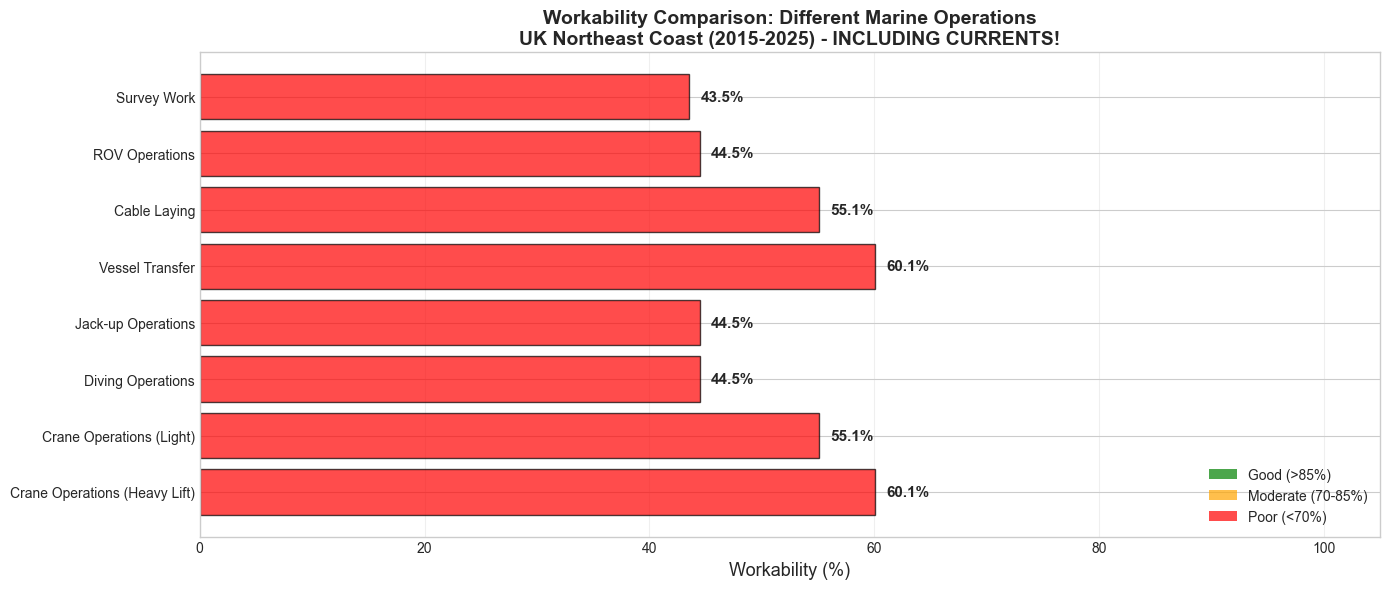


💡 What this means for project planning:
   • Easiest operation: Crane Operations (Heavy Lift) (60.1% workable)
   • Hardest operation: Survey Work (43.5% workable)
   • Planning buffer: Always add 10-20% contingency for weather delays

⚠️  Notice: Workability decreased compared to wave+wind only!
   This is because currents add an additional constraint.


In [7]:
# Calculate workability for all operations (with currents!)
results = {}
for op_name, limits in operations.items():
    result = calculate_workability_multi(
        df,
        limits['max_hs'],
        limits['max_wind'],
        limits['max_current']  # Now includes currents!
    )
    results[op_name] = result['workability']

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 6))

op_names = list(results.keys())
workabilities = list(results.values())

# Color code by workability level
colors = ['red' if w < 70 else 'orange' if w < 85 else 'green' for w in workabilities]

bars = ax.barh(op_names, workabilities, color=colors, alpha=0.7, edgecolor='black')

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, workabilities)):
    ax.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Workability (%)', fontsize=13)
ax.set_title('Workability Comparison: Different Marine Operations\nUK Northeast Coast (2015-2025) - INCLUDING CURRENTS!', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, 105)
ax.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Good (>85%)'),
    Patch(facecolor='orange', alpha=0.7, label='Moderate (70-85%)'),
    Patch(facecolor='red', alpha=0.7, label='Poor (<70%)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("\n💡 What this means for project planning:")
best_op = max(results, key=results.get)
worst_op = min(results, key=results.get)
print(f"   • Easiest operation: {best_op} ({results[best_op]:.1f}% workable)")
print(f"   • Hardest operation: {worst_op} ({results[worst_op]:.1f}% workable)")
print(f"   • Planning buffer: Always add 10-20% contingency for weather delays")
print(f"\n⚠️  Notice: Workability decreased compared to wave+wind only!")
print(f"   This is because currents add an additional constraint.")

---
## Part 6: Monthly Workability Analysis

**Key question:** What are the best months to schedule your project?

In [8]:
# Add month column
df['month'] = pd.to_datetime(df['time']).dt.month

# Choose one operation to analyze (Crane Operations Heavy Lift)
operation = 'Crane Operations (Heavy Lift)'
max_hs = operations[operation]['max_hs']
max_wind = operations[operation]['max_wind']
max_current = operations[operation]['max_current']

print(f"=" * 80)
print(f"📅 MONTHLY WORKABILITY: {operation}")
print(f"=" * 80)
print(f"\nLimits: Hs < {max_hs}m, Wind < {max_wind}m/s, Current < {max_current}kt\n")

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

monthly_workability = []

for month in range(1, 13):
    month_data = df[df['month'] == month]
    
    if len(month_data) > 0:
        # Calculate workability for this month (with currents!)
        result = calculate_workability_multi(month_data, max_hs, max_wind, max_current)
        workability = result['workability']
        
        monthly_workability.append(workability)
        
        # Status indicator
        if workability > 90:
            status = "🟢 Excellent"
        elif workability > 80:
            status = "🟡 Good"
        elif workability > 70:
            status = "🟠 Fair"
        else:
            status = "🔴 Poor"
        
        print(f"{month_names[month-1]:>3s}: {workability:5.1f}% workable  {status}")
    else:
        monthly_workability.append(0)

# Find best and worst months
best_month_idx = monthly_workability.index(max(monthly_workability))
worst_month_idx = monthly_workability.index(min(monthly_workability))

print(f"\n💡 Insights:")
print(f"   • Best month: {month_names[best_month_idx]} ({monthly_workability[best_month_idx]:.1f}% workable)")
print(f"   • Worst month: {month_names[worst_month_idx]} ({monthly_workability[worst_month_idx]:.1f}% workable)")

# Summer vs Winter
summer_months = [4, 5, 6, 7, 8]  # May-Aug
winter_months = [11, 12, 1, 2]    # Dec-Feb

summer_avg = np.mean([monthly_workability[m-1] for m in summer_months if monthly_workability[m-1] > 0])
winter_avg = np.mean([monthly_workability[m-1] for m in winter_months if monthly_workability[m-1] > 0])

print(f"\n📊 Seasonal comparison:")
print(f"   • Summer (May-Aug): {summer_avg:.1f}% average workability")
print(f"   • Winter (Dec-Feb): {winter_avg:.1f}% average workability")
print(f"   • Difference: {summer_avg - winter_avg:.1f}% points")

print(f"\n⚠️  Current impact:")
print(f"   Currents are now factored into monthly workability")
print(f"   This gives a more realistic estimate for planning!")

📅 MONTHLY WORKABILITY: Crane Operations (Heavy Lift)

Limits: Hs < 2.0m, Wind < 15.0m/s, Current < 1.5kt

Jan:  47.2% workable  🔴 Poor
Feb:  48.8% workable  🔴 Poor
Mar:  57.7% workable  🔴 Poor
Apr:  62.3% workable  🔴 Poor
May:  63.9% workable  🔴 Poor
Jun:  66.5% workable  🔴 Poor
Jul:  68.5% workable  🔴 Poor
Aug:  69.5% workable  🔴 Poor
Sep:  66.4% workable  🔴 Poor
Oct:  59.8% workable  🔴 Poor
Nov:  53.6% workable  🔴 Poor
Dec:  55.6% workable  🔴 Poor

💡 Insights:
   • Best month: Aug (69.5% workable)
   • Worst month: Jan (47.2% workable)

📊 Seasonal comparison:
   • Summer (May-Aug): 66.1% average workability
   • Winter (Dec-Feb): 51.3% average workability
   • Difference: 14.8% points

⚠️  Current impact:
   Currents are now factored into monthly workability
   This gives a more realistic estimate for planning!


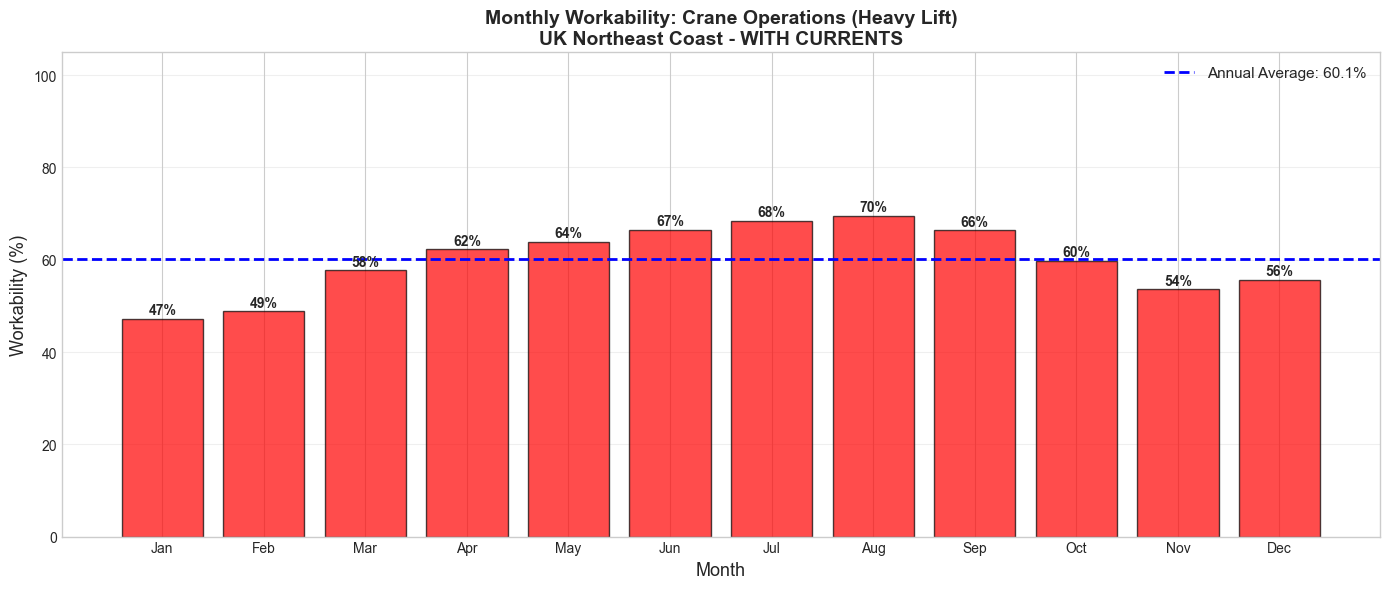


🎯 Project planning recommendation:
   Best months for scheduling: Apr, May, Jun, Jul, Aug, Sep
   Avoid if possible: Jan

⚠️  Remember: These figures now include current limits!
   More realistic than wave+wind only.


In [9]:
# Plot monthly workability
fig, ax = plt.subplots(figsize=(14, 6))

months = range(1, 13)
colors_monthly = ['red' if w < 70 else 'orange' if w < 85 else 'green' for w in monthly_workability]

bars = ax.bar(months, monthly_workability, color=colors_monthly, alpha=0.7, edgecolor='black')

# Add percentage labels
for month, bar, pct in zip(months, bars, monthly_workability):
    ax.text(month, pct + 1, f'{pct:.0f}%', ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(months)
ax.set_xticklabels(month_names)
ax.set_ylabel('Workability (%)', fontsize=13)
ax.set_xlabel('Month', fontsize=13)
ax.set_title(f'Monthly Workability: {operation}\nUK Northeast Coast - WITH CURRENTS', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3, axis='y')

# Add horizontal line for annual average
annual_avg = calculate_workability_multi(df, max_hs, max_wind, max_current)['workability']
ax.axhline(annual_avg, color='blue', linestyle='--', linewidth=2, 
           label=f'Annual Average: {annual_avg:.1f}%')
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\n🎯 Project planning recommendation:")
good_months = [month_names[i] for i, w in enumerate(monthly_workability) if w > annual_avg]
print(f"   Best months for scheduling: {', '.join(good_months)}")
print(f"   Avoid if possible: {', '.join([month_names[worst_month_idx]])}")
print(f"\n⚠️  Remember: These figures now include current limits!")
print(f"   More realistic than wave+wind only.")

---
## Part 7: Scatter Diagram with Workability Overlay

Let's visualize which parts of the scatter diagram are "workable" and which are "not workable".

In [10]:
# Add workability flag to scatter diagram
operation = 'Diving Operations'
max_hs_limit = operations[operation]['max_hs']

print(f"=" * 80)
print(f"🎯 WORKABILITY ZONES ON SCATTER DIAGRAM")
print(f"=" * 80)
print(f"\nOperation: {operation}")
print(f"Limit: Hs < {max_hs_limit}m\n")

# Mark each cell as workable or not
scatter_df['workable'] = scatter_df['hs_bin'] < max_hs_limit

# Calculate workable vs non-workable hours
workable_hours = scatter_df[scatter_df['workable']]['frequency'].sum()
non_workable_hours = scatter_df[~scatter_df['workable']]['frequency'].sum()
total_hours = scatter_df['frequency'].sum()

workability = (workable_hours / total_hours) * 100

print(f"✅ Workable zone:")
print(f"   {workable_hours:,} hours ({workability:.1f}%)")
print(f"\n❌ Non-workable zone:")
print(f"   {non_workable_hours:,} hours ({100-workability:.1f}%)")

🎯 WORKABILITY ZONES ON SCATTER DIAGRAM

Operation: Diving Operations
Limit: Hs < 1.5m

✅ Workable zone:
   10,686 hours (67.4%)

❌ Non-workable zone:
   5,173 hours (32.6%)


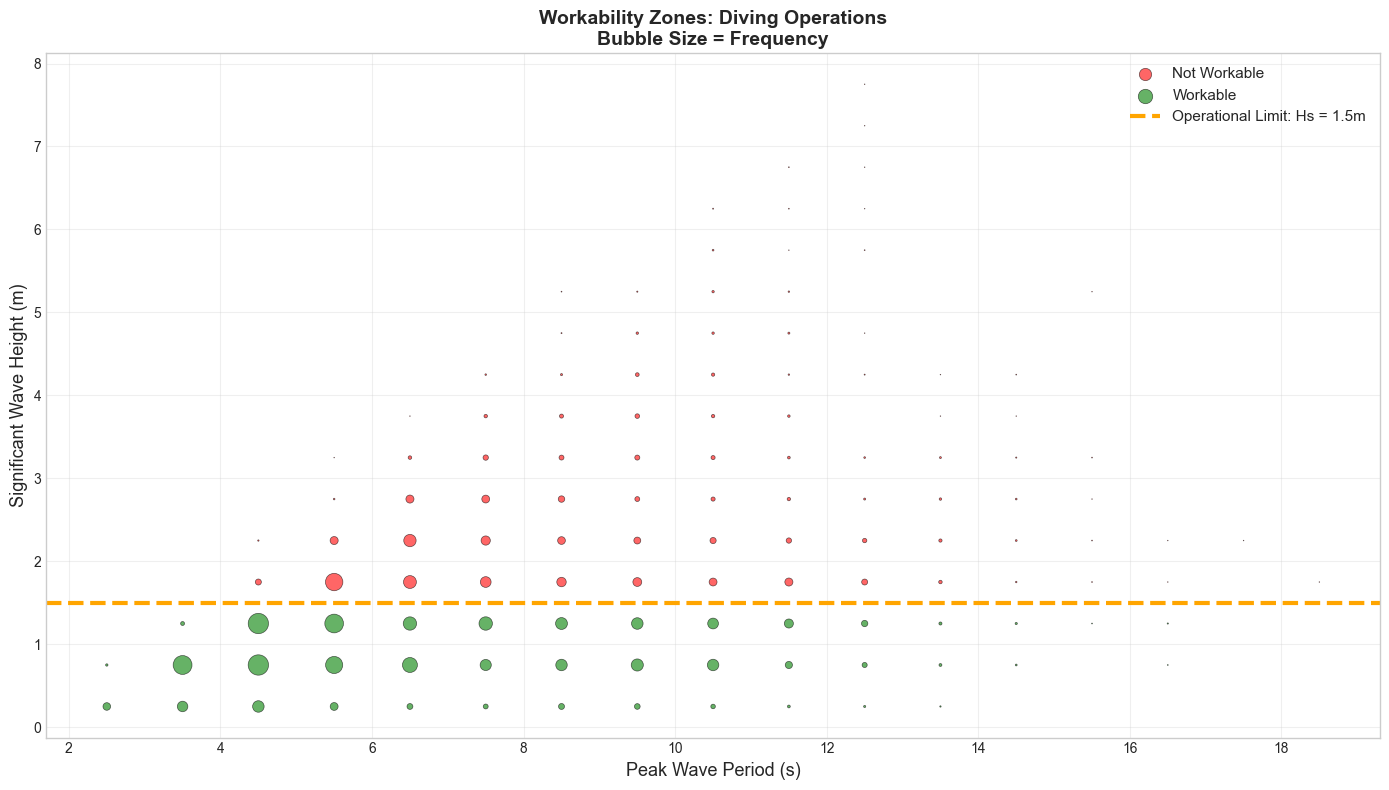


💡 Interpretation:
   • Green zone = Conditions allow work
   • Red zone = Conditions too rough for work
   • Bigger bubbles = More frequent conditions
   • Most big green bubbles = Good workability location!


In [11]:
# Plot scatter diagram with workability zones
fig, ax = plt.subplots(figsize=(14, 8))

# Separate workable and non-workable points
workable_data = scatter_df[scatter_df['workable']]
non_workable_data = scatter_df[~scatter_df['workable']]

# Plot non-workable (red)
ax.scatter(non_workable_data['tp_bin'], non_workable_data['hs_bin'],
          s=non_workable_data['frequency']/5, c='red', alpha=0.6,
          edgecolors='black', linewidth=0.5, label='Not Workable')

# Plot workable (green)
ax.scatter(workable_data['tp_bin'], workable_data['hs_bin'],
          s=workable_data['frequency']/5, c='green', alpha=0.6,
          edgecolors='black', linewidth=0.5, label='Workable')

# Add limit line
ax.axhline(max_hs_limit, color='orange', linestyle='--', linewidth=3,
          label=f'Operational Limit: Hs = {max_hs_limit}m')

ax.set_xlabel('Peak Wave Period (s)', fontsize=13)
ax.set_ylabel('Significant Wave Height (m)', fontsize=13)
ax.set_title(f'Workability Zones: {operation}\nBubble Size = Frequency', 
            fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • Green zone = Conditions allow work")
print("   • Red zone = Conditions too rough for work")
print("   • Bigger bubbles = More frequent conditions")
print("   • Most big green bubbles = Good workability location!")

---
## Part 8: Project Duration Analysis

**Key question:** If I have a 30-day project, how many actual working days will I get?

In [12]:
def estimate_project_duration(project_work_days, workability_pct, p_levels=[50, 80, 90]):
    """
    Estimate total project duration with P50/P80/P90 confidence levels
    
    Args:
        project_work_days: Days of actual work needed
        workability_pct: % of time work is possible
        p_levels: Confidence levels (default: P50, P80, P90)
    
    Returns:
        dict with project estimates for each P-level
    """
    # Convert to decimal
    workability = workability_pct / 100
    
    # Base calendar days (no contingency)
    calendar_days_base = project_work_days / workability
    
    # P-level multipliers (industry standard for offshore)
    p_multipliers = {
        50: 1.00,  # P50 - Median case (50% confidence)
        80: 1.20,  # P80 - Typical planning (80% confidence)
        90: 1.35,  # P90 - Conservative (90% confidence)
        95: 1.50   # P95 - Very conservative (95% confidence)
    }
    
    results = {
        'work_days': project_work_days,
        'workability_pct': workability_pct,
        'calendar_days_base': calendar_days_base,
        'weather_delays_base': calendar_days_base - project_work_days,
        'p_levels': {}
    }
    
    for p_level in p_levels:
        multiplier = p_multipliers.get(p_level, 1.0)
        calendar_days = calendar_days_base * multiplier
        contingency_days = calendar_days - calendar_days_base
        
        results['p_levels'][p_level] = {
            'multiplier': multiplier,
            'calendar_days': calendar_days,
            'contingency_days': contingency_days,
            'months': calendar_days / 30,
            'confidence': f"{p_level}% confidence to complete on time"
        }
    
    return results


print("=" * 80)
print("📅 PROJECT DURATION ESTIMATES WITH P50/P80/P90 CONFIDENCE LEVELS")
print("=" * 80)

# Example projects
projects = [
    ('Short project', 14),
    ('Medium project', 30),
    ('Long project', 100)
]

# Use crane operations as example (WITH CURRENTS!)
operation = 'Diving Operations'
workability = calculate_workability_multi(
    df, 
    operations[operation]['max_hs'],
    operations[operation]['max_wind'],
    operations[operation]['max_current']
)['workability']

print(f"\n🚢 Operation: {operation}")
print(f"📊 Limits: Hs<{operations[operation]['max_hs']}m, Wind<{operations[operation]['max_wind']}m/s, Current<{operations[operation]['max_current']}kt")
print(f"✅ Workability: {workability:.1f}% (with wave+wind+current limits)")
print(f"\n{'='*80}\n")

for project_name, work_days in projects:
    result = estimate_project_duration(work_days, workability, p_levels=[50, 80, 90])
    
    print(f"📊 {project_name.upper()} ({work_days} working days needed)")
    print(f"   Workability: {workability:.1f}%")
    print(f"   Base duration (no contingency): {result['calendar_days_base']:.0f} days")
    print(f"   Weather delays (base): {result['weather_delays_base']:.0f} days")
    print(f"")
    print(f"   📈 P-Level Estimates:")
    
    for p_level in [50, 80, 90]:
        p_data = result['p_levels'][p_level]
        
        # Status indicator
        if p_level == 50:
            icon = "⚠️ "
            note = " (Risky - 50/50 chance)"
        elif p_level == 80:
            icon = "✅ "
            note = " (Recommended for planning)"
        else:
            icon = "🔒 "
            note = " (Conservative - high confidence)"
        
        print(f"   {icon}P{p_level}: {p_data['calendar_days']:>4.0f} days ({p_data['months']:>4.1f} months) "
              f"+ {p_data['contingency_days']:>3.0f} days contingency{note}")
    
    print(f"\n   💡 Recommendation: Use P80 ({result['p_levels'][80]['calendar_days']:.0f} days) for client proposals")
    print(f"      Use P90 ({result['p_levels'][90]['calendar_days']:.0f} days) for critical path items")
    print(f"\n{'-'*80}\n")

print("\n" + "=" * 80)
print("📖 UNDERSTANDING P-LEVELS")
print("=" * 80)

print("""
P-levels represent CONFIDENCE that project will complete within estimated time:

• P50 (Median):
  - 50% chance to finish on time
  - Use for: Internal estimates, rough planning
  - Risk: High - essentially a coin flip!

• P80 (Typical):
  - 80% chance to finish on time
  - Use for: Client proposals, budget planning
  - Risk: Moderate - standard industry practice

• P90 (Conservative):
  - 90% chance to finish on time  
  - Use for: Critical path, tight weather windows
  - Risk: Low - high confidence

Industry Best Practice:
  → Bid with P80, plan critical items with P90
  → Never use P50 for client commitments!
  → Add separate risk contingency for Black Swan events
""")

print("\n⚠️ These estimates now include CURRENT limits!")
print("   More realistic than wave+wind only.")

📅 PROJECT DURATION ESTIMATES WITH P50/P80/P90 CONFIDENCE LEVELS

🚢 Operation: Diving Operations
📊 Limits: Hs<1.5m, Wind<15.0m/s, Current<1.0kt
✅ Workability: 44.5% (with wave+wind+current limits)


📊 SHORT PROJECT (14 working days needed)
   Workability: 44.5%
   Base duration (no contingency): 31 days
   Weather delays (base): 17 days

   📈 P-Level Estimates:
   ⚠️ P50:   31 days ( 1.0 months) +   0 days contingency (Risky - 50/50 chance)
   ✅ P80:   38 days ( 1.3 months) +   6 days contingency (Recommended for planning)
   🔒 P90:   42 days ( 1.4 months) +  11 days contingency (Conservative - high confidence)

   💡 Recommendation: Use P80 (38 days) for client proposals
      Use P90 (42 days) for critical path items

--------------------------------------------------------------------------------

📊 MEDIUM PROJECT (30 working days needed)
   Workability: 44.5%
   Base duration (no contingency): 67 days
   Weather delays (base): 37 days

   📈 P-Level Estimates:
   ⚠️ P50:   67 days ( 2

In [13]:
def calculate_workability_per_record(df, max_hs, max_wind, max_current=None):
    """
    Check if each 6-hour record is workable
    Returns boolean array for Monte Carlo
    
    NOTE: For Monte Carlo P-levels, we recommend using wave+wind only!
    Tidal currents should be handled separately via slack tide analysis.
    """
    hs_ok = df['hs'] < max_hs
    wind_ok = df['wind_speed'] < max_wind
    
    if max_current is not None:
        has_current = df['current_speed_knots_max'].notna()
        current_ok = df['current_speed_knots_max'] < max_current
        
        # All 3 criteria where current data exists, wave+wind only elsewhere
        workable = hs_ok & wind_ok & ((~has_current) | current_ok)
    else:
        # Wave + wind only (RECOMMENDED for Monte Carlo)
        workable = hs_ok & wind_ok
    
    return workable.values


def monte_carlo_simulation(df, workable_array, work_days, n_simulations=10000):
    """
    🎲 THE MONTE CARLO ENGINE!
    
    Simulates project starting at random dates using REAL weather
    
    Returns distribution of project durations for P-level calculation
    """
    durations = []
    total_records = len(df)
    work_periods_needed = work_days * 4  # 4 x 6-hour periods per day
    
    print(f"🎲 Running {n_simulations:,} simulations...")
    print(f"   Project: {work_days} work days = {work_periods_needed} 6-hour periods")
    print(f"   Dataset: {total_records:,} records (2015-2025)")
    print(f"   This takes ~30 seconds... ☕\n")
    
    for sim in range(n_simulations):
        if sim % 2000 == 0 and sim > 0:
            print(f"   Progress: {sim:,} / {n_simulations:,} simulations...")
        
        max_start = total_records - work_periods_needed - 100
        if max_start < 0:
            print(f"\n⚠️ WARNING: Not enough data!")
            break
            
        start_idx = np.random.randint(0, max_start)
        
        periods_completed = 0
        calendar_periods = 0
        current_idx = start_idx
        
        while periods_completed < work_periods_needed and current_idx < total_records:
            if workable_array[current_idx]:
                periods_completed += 1
            calendar_periods += 1
            current_idx += 1
        
        # Only add if project completed
        if periods_completed >= work_periods_needed:
            calendar_days = calendar_periods / 4
            durations.append(calendar_days)
    
    print(f"✅ Completed {len(durations):,} valid simulations!\n")
    
    return np.array(durations)


def calculate_monte_carlo_p_levels(durations):
    """
    Calculate P-level multipliers from Monte Carlo results
    """
    if len(durations) == 0:
        return None
        
    p50 = np.percentile(durations, 50)
    p80 = np.percentile(durations, 80)
    p90 = np.percentile(durations, 90)
    
    return {
        'p50': p50,
        'p80': p80,
        'p90': p90,
        'mult_p80': p80 / p50 if p50 > 0 else 1.0,
        'mult_p90': p90 / p50 if p50 > 0 else 1.0,
    }

print("✅ Monte Carlo functions defined!")
print("   💡 For nearshore work: Use wave+wind for P-levels, handle tidal slack separately")

✅ Monte Carlo functions defined!
   💡 For nearshore work: Use wave+wind for P-levels, handle tidal slack separately


In [15]:
# Run Monte Carlo for Diving Operations (WAVE + WIND ONLY)
operation = 'Diving Operations'
limits = operations[operation]

print("=" * 80)
print(f"🎲 MONTE CARLO SIMULATION: {operation}")
print("=" * 80)
print(f"\nLimits: Hs<{limits['max_hs']}m, Wind<{limits['max_wind']}m/s")
print(f"⚠️  NOTE: Using WAVE + WIND only (currents handled separately via tidal slack)")

# Calculate workability array (NO CURRENTS for Monte Carlo!)
workable = calculate_workability_per_record(
    df, limits['max_hs'], limits['max_wind'], max_current=None  # NO CURRENT!
)

overall_workability = (workable.sum() / len(workable)) * 100
print(f"Overall workability (wave+wind): {overall_workability:.1f}%")

# Run Monte Carlo for 14-day project
work_days = 14
print(f"\n🎯 Simulating {work_days}-day project...")

durations = monte_carlo_simulation(df, workable, work_days, n_simulations=1000000)

# Calculate P-levels from Monte Carlo
mc_results = calculate_monte_carlo_p_levels(durations)

if mc_results is None:
    print("\n❌ Monte Carlo failed - not enough data!")
else:
    # Calculate theoretical values
    theoretical_p50 = work_days / (overall_workability / 100)
    
    print("=" * 80)
    print("📊 RESULTS: MONTE CARLO vs INDUSTRY STANDARD")
    print("=" * 80)
    
    print(f"\n🎲 MONTE CARLO (from YOUR weather data):")
    print(f"   P50: {mc_results['p50']:.0f} days (median)")
    print(f"   P80: {mc_results['p80']:.0f} days (×{mc_results['mult_p80']:.3f})")
    print(f"   P90: {mc_results['p90']:.0f} days (×{mc_results['mult_p90']:.3f})")
    
    print(f"\n📚 INDUSTRY STANDARD (generic):")
    print(f"   P50: {theoretical_p50:.0f} days")
    print(f"   P80: {theoretical_p50 * 1.20:.0f} days (×1.200)")
    print(f"   P90: {theoretical_p50 * 1.35:.0f} days (×1.350)")
    
    diff_p80 = mc_results['p80'] - (theoretical_p50 * 1.20)
    diff_p90 = mc_results['p90'] - (theoretical_p50 * 1.35)
    print(f"\n💡 DIFFERENCE:")
    print(f"   P80: {diff_p80:+.0f} days ({diff_p80/theoretical_p50*100:+.1f}%)")
    print(f"   P90: {diff_p90:+.0f} days ({diff_p90/theoretical_p50*100:+.1f}%)")
    
    print(f"\n🎯 RECOMMENDATION:")
    print(f"   Use YOUR site-specific multipliers for WEATHER risk:")
    print(f"   • P80 = ×{mc_results['mult_p80']:.3f} (not generic ×1.200)")
    print(f"   • P90 = ×{mc_results['mult_p90']:.3f} (not generic ×1.350)")
    print(f"\n   ⚠️  These P-levels cover WEATHER risk only (wave + wind)")
    print(f"   🌊 For TIDAL CURRENTS: Apply slack tide window analysis separately")

🎲 MONTE CARLO SIMULATION: Diving Operations

Limits: Hs<1.5m, Wind<15.0m/s
⚠️  NOTE: Using WAVE + WIND only (currents handled separately via tidal slack)
Overall workability (wave+wind): 67.4%

🎯 Simulating 14-day project...
🎲 Running 1,000,000 simulations...
   Project: 14 work days = 56 6-hour periods
   Dataset: 15,859 records (2015-2025)
   This takes ~30 seconds... ☕

   Progress: 2,000 / 1,000,000 simulations...
   Progress: 4,000 / 1,000,000 simulations...
   Progress: 6,000 / 1,000,000 simulations...
   Progress: 8,000 / 1,000,000 simulations...
   Progress: 10,000 / 1,000,000 simulations...
   Progress: 12,000 / 1,000,000 simulations...
   Progress: 14,000 / 1,000,000 simulations...
   Progress: 16,000 / 1,000,000 simulations...
   Progress: 18,000 / 1,000,000 simulations...
   Progress: 20,000 / 1,000,000 simulations...
   Progress: 22,000 / 1,000,000 simulations...
   Progress: 24,000 / 1,000,000 simulations...
   Progress: 26,000 / 1,000,000 simulations...
   Progress: 28,0

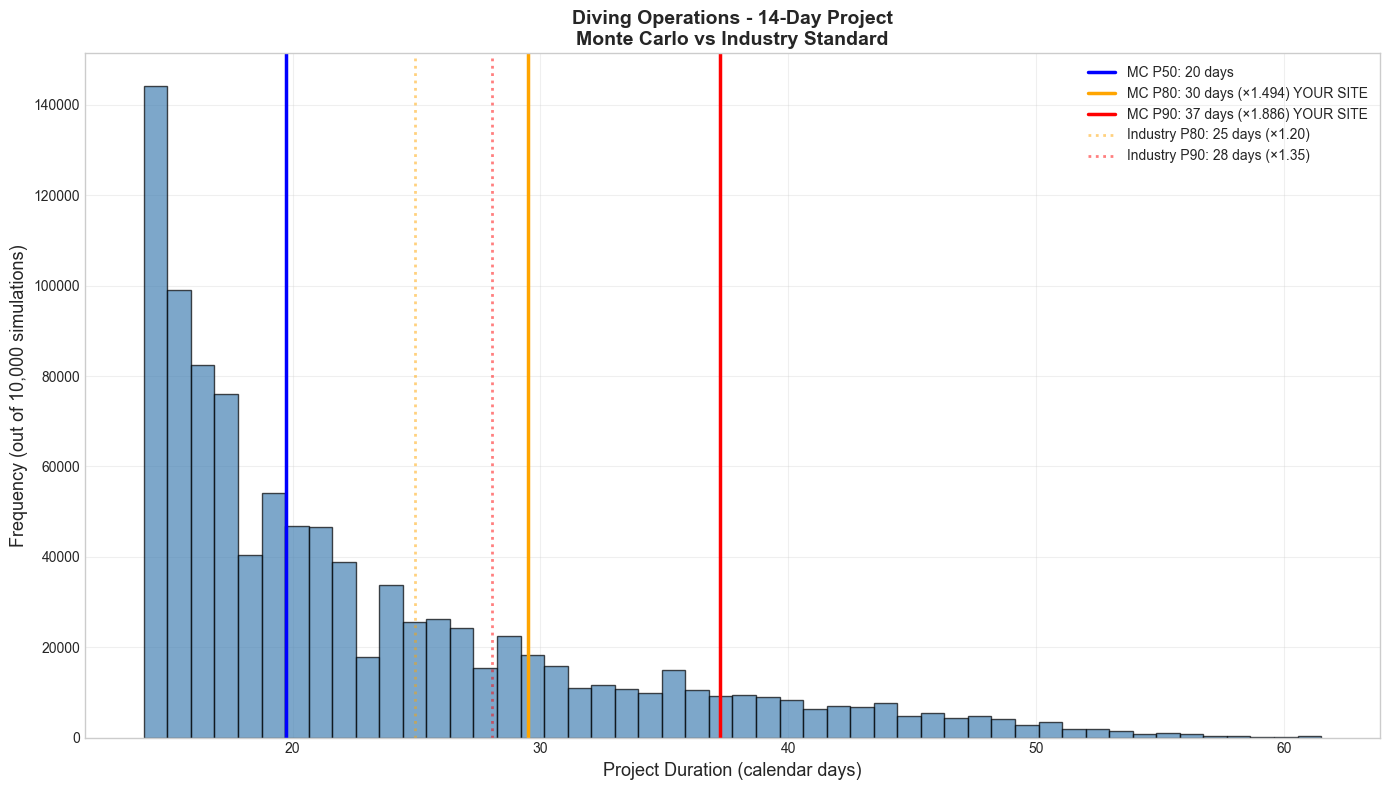


💡 Solid lines = YOUR site-specific P-levels
   Dotted lines = Generic industry standard

✅ Your site-specific multipliers account for UK Northeast Coast weather patterns!


In [16]:
# Visualize Monte Carlo distribution
fig, ax = plt.subplots(figsize=(14, 8))

# Histogram
ax.hist(durations, bins=50, alpha=0.7, color='steelblue', edgecolor='black')

# Monte Carlo P-levels (solid lines)
ax.axvline(mc_results['p50'], color='blue', linestyle='-', linewidth=2.5,
          label=f'MC P50: {mc_results["p50"]:.0f} days')
ax.axvline(mc_results['p80'], color='orange', linestyle='-', linewidth=2.5,
          label=f'MC P80: {mc_results["p80"]:.0f} days (×{mc_results["mult_p80"]:.3f}) YOUR SITE')
ax.axvline(mc_results['p90'], color='red', linestyle='-', linewidth=2.5,
          label=f'MC P90: {mc_results["p90"]:.0f} days (×{mc_results["mult_p90"]:.3f}) YOUR SITE')

# Industry standard (dotted lines)
ax.axvline(theoretical_p50 * 1.20, color='orange', linestyle=':', linewidth=2,
          alpha=0.5, label=f'Industry P80: {theoretical_p50 * 1.20:.0f} days (×1.20)')
ax.axvline(theoretical_p50 * 1.35, color='red', linestyle=':', linewidth=2,
          alpha=0.5, label=f'Industry P90: {theoretical_p50 * 1.35:.0f} days (×1.35)')

ax.set_xlabel('Project Duration (calendar days)', fontsize=13)
ax.set_ylabel('Frequency (out of 10,000 simulations)', fontsize=13)
ax.set_title(f'{operation} - {work_days}-Day Project\nMonte Carlo vs Industry Standard',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Solid lines = YOUR site-specific P-levels")
print("   Dotted lines = Generic industry standard")
print(f"\n✅ Your site-specific multipliers account for UK Northeast Coast weather patterns!")

---
## Part 8B: Monte Carlo Simulation for Site-Specific P-Levels

**The Problem:** Industry standard P-levels (1.20, 1.35) are generic "one-size-fits-all" multipliers.

**The Solution:** Use Monte Carlo simulation with YOUR actual weather data to derive site-specific P-levels!

**How it works:**
1. Pick random start date in your 10-year dataset
2. Simulate project day-by-day checking workability
3. Count how many calendar days it takes to complete the work
4. Repeat 10,000 times
5. Calculate P50/P80/P90 from the distribution of results

**Why this is better:**
- Based on YOUR location's weather patterns
- Accounts for weather clustering (storms come in groups!)
- Includes seasonality (winter vs summer)
- NO ASSUMPTIONS - pure data-driven!

**IMPORTANT for Nearshore Work:**
- Monte Carlo uses **WAVE + WIND only** for P-levels
- **Tidal currents** are handled separately (see Part 8C)
- Why? Tides are predictable, weather is random
- This gives you **weather risk multipliers** to apply on top of tidal constraints

Let's run it! 🎲

In [18]:
# EXAMPLE: Monte Carlo for OTHER operations (wave+wind only)
# You can run this for any operation - just change the operation name

operation = 'Crane Operations (Heavy Lift)'
limits = operations[operation]

print("=" * 80)
print(f"🎲 MONTE CARLO EXAMPLE: {operation}")
print("=" * 80)
print(f"\nLimits: Hs<{limits['max_hs']}m, Wind<{limits['max_wind']}m/s")
print(f"⚠️  Using WAVE + WIND only for P-level calculation")

# Calculate workability array (NO CURRENTS!)
workable = calculate_workability_per_record(
    df, limits['max_hs'], limits['max_wind'], max_current=None
)

overall_workability = (workable.sum() / len(workable)) * 100
print(f"Overall workability (wave+wind): {overall_workability:.1f}%")

# Run Monte Carlo for 30-day project
work_days = 30
print(f"\n🎯 Simulating {work_days}-day project...")

durations = monte_carlo_simulation(df, workable, work_days, n_simulations=1000000)

# Calculate P-levels from Monte Carlo
mc_results = calculate_monte_carlo_p_levels(durations)

if mc_results is None:
    print("\n❌ Monte Carlo failed!")
else:
    theoretical_p50 = work_days / (overall_workability / 100)
    
    print("\n" + "=" * 80)
    print("📊 RESULTS: MONTE CARLO vs INDUSTRY STANDARD")
    print("=" * 80)
    
    print(f"\n🎲 MONTE CARLO (UK Northeast Coast 2015-2025):")
    print(f"   P50: {mc_results['p50']:.0f} days (median)")
    print(f"   P80: {mc_results['p80']:.0f} days (×{mc_results['mult_p80']:.3f})")
    print(f"   P90: {mc_results['p90']:.0f} days (×{mc_results['mult_p90']:.3f})")
    
    print(f"\n📚 INDUSTRY STANDARD (generic):")
    print(f"   P50: {theoretical_p50:.0f} days")
    print(f"   P80: {theoretical_p50 * 1.20:.0f} days (×1.200)")
    print(f"   P90: {theoretical_p50 * 1.35:.0f} days (×1.350)")
    
    diff_p80 = mc_results['p80'] - (theoretical_p50 * 1.20)
    diff_p90 = mc_results['p90'] - (theoretical_p50 * 1.35)
    print(f"\n💡 DIFFERENCE:")
    print(f"   P80: {diff_p80:+.0f} days ({diff_p80/theoretical_p50*100:+.1f}%)")
    print(f"   P90: {diff_p90:+.0f} days ({diff_p90/theoretical_p50*100:+.1f}%)")
    
    if abs(mc_results['mult_p80'] - 1.20) < 0.05:
        print(f"\n✅ Your site matches industry standard well!")
    elif mc_results['mult_p80'] > 1.25:
        print(f"\n⚠️  Your site has HIGHER weather variability!")
        print(f"   Use Monte Carlo multipliers for more accurate estimates.")
    else:
        print(f"\n✅ Your site has LOWER weather variability!")
    
    print(f"\n🎯 RECOMMENDATION:")
    print(f"   Use site-specific Monte Carlo multipliers:")
    print(f"   • P80 = ×{mc_results['mult_p80']:.3f}")
    print(f"   • P90 = ×{mc_results['mult_p90']:.3f}")
    print(f"\n   These account for UK Northeast Coast weather patterns!")

🎲 MONTE CARLO EXAMPLE: Crane Operations (Heavy Lift)

Limits: Hs<2.0m, Wind<15.0m/s
⚠️  Using WAVE + WIND only for P-level calculation
Overall workability (wave+wind): 83.2%

🎯 Simulating 30-day project...
🎲 Running 1,000,000 simulations...
   Project: 30 work days = 120 6-hour periods
   Dataset: 15,859 records (2015-2025)
   This takes ~30 seconds... ☕

   Progress: 2,000 / 1,000,000 simulations...
   Progress: 4,000 / 1,000,000 simulations...
   Progress: 6,000 / 1,000,000 simulations...
   Progress: 8,000 / 1,000,000 simulations...
   Progress: 10,000 / 1,000,000 simulations...
   Progress: 12,000 / 1,000,000 simulations...
   Progress: 14,000 / 1,000,000 simulations...
   Progress: 16,000 / 1,000,000 simulations...
   Progress: 18,000 / 1,000,000 simulations...
   Progress: 20,000 / 1,000,000 simulations...
   Progress: 22,000 / 1,000,000 simulations...
   Progress: 24,000 / 1,000,000 simulations...
   Progress: 26,000 / 1,000,000 simulations...
   Progress: 28,000 / 1,000,000 sim

In [20]:
# Run Monte Carlo for Crane Operations (Heavy Lift)
operation = 'Crane Operations (Heavy Lift)'
limits = operations[operation]

print("=" * 80)
print(f"🎲 MONTE CARLO SIMULATION: {operation}")
print("=" * 80)
print(f"\nLimits: Hs<{limits['max_hs']}m, Wind<{limits['max_wind']}m/s, Current<{limits['max_current']}kt")

# Calculate workability array (boolean for each 6-hour record)
workable = calculate_workability_per_record(
    df, limits['max_hs'], limits['max_wind'], limits['max_current']
)

overall_workability = (workable.sum() / len(workable)) * 100
print(f"Overall workability: {overall_workability:.1f}%")

# Run Monte Carlo for 30-day project (USING 2022-2025 DATA ONLY!)
work_days = 30
print(f"\n🎯 Simulating {work_days}-day project starting at random dates...")

durations = monte_carlo_simulation(df, workable, work_days, n_simulations=1000000)

# Calculate P-levels from Monte Carlo
mc_results = calculate_monte_carlo_p_levels(durations)

if mc_results is None:
    print("\n❌ Monte Carlo failed - not enough data!")
else:
    # Calculate theoretical values using industry standard
    theoretical_p50 = work_days / (overall_workability / 100)
    
    print("\n" + "=" * 80)
    print("📊 RESULTS: MONTE CARLO vs INDUSTRY STANDARD")
    print("=" * 80)
    
    print(f"\n🎲 MONTE CARLO (from YOUR weather data - 2022-2025):")
    print(f"   P50: {mc_results['p50']:.0f} days (median)")
    print(f"   P80: {mc_results['p80']:.0f} days (×{mc_results['mult_p80']:.3f} multiplier)")
    print(f"   P90: {mc_results['p90']:.0f} days (×{mc_results['mult_p90']:.3f} multiplier)")
    
    print(f"\n📚 INDUSTRY STANDARD (generic multipliers):")
    print(f"   P50: {theoretical_p50:.0f} days")
    print(f"   P80: {theoretical_p50 * 1.20:.0f} days (×1.200 multiplier)")
    print(f"   P90: {theoretical_p50 * 1.35:.0f} days (×1.350 multiplier)")
    
    print(f"\n💡 DIFFERENCE (Monte Carlo - Standard):")
    diff_p80 = mc_results['p80'] - (theoretical_p50 * 1.20)
    diff_p90 = mc_results['p90'] - (theoretical_p50 * 1.35)
    print(f"   P80: {diff_p80:+.0f} days ({diff_p80/theoretical_p50*100:+.1f}%)")
    print(f"   P90: {diff_p90:+.0f} days ({diff_p90/theoretical_p50*100:+.1f}%)")
    
    if abs(mc_results['mult_p80'] - 1.20) < 0.05:
        print(f"\n✅ Your site matches industry standard well!")
    elif mc_results['mult_p80'] > 1.25:
        print(f"\n⚠️  Your site has HIGHER weather variability than standard!")
        print(f"   Use Monte Carlo multipliers for more accurate estimates.")
    else:
        print(f"\n✅ Your site has LOWER weather variability than standard!")
        print(f"   You may complete projects faster than generic estimates suggest.")
    
    
    print(f"\n🎯 RECOMMENDATION:")
    print(f"   Use YOUR site-specific Monte Carlo multipliers:")
    print(f"   • P80 = ×{mc_results['mult_p80']:.3f} (not generic ×1.200)")
    print(f"   • P90 = ×{mc_results['mult_p90']:.3f} (not generic ×1.350)")
    print(f"\n   These account for YOUR location's actual weather clustering and seasonality!")
    print(f"   ⚠️ Based on 2022-2025 data with complete wave+wind+current coverage")

🎲 MONTE CARLO SIMULATION: Crane Operations (Heavy Lift)

Limits: Hs<2.0m, Wind<15.0m/s, Current<1.5kt
Overall workability: 60.1%

🎯 Simulating 30-day project starting at random dates...
🎲 Running 1,000,000 simulations...
   Project: 30 work days = 120 6-hour periods
   Dataset: 15,859 records (2015-2025)
   This takes ~30 seconds... ☕

   Progress: 2,000 / 1,000,000 simulations...
   Progress: 4,000 / 1,000,000 simulations...
   Progress: 6,000 / 1,000,000 simulations...
   Progress: 8,000 / 1,000,000 simulations...
   Progress: 10,000 / 1,000,000 simulations...
   Progress: 12,000 / 1,000,000 simulations...
   Progress: 14,000 / 1,000,000 simulations...
   Progress: 16,000 / 1,000,000 simulations...
   Progress: 18,000 / 1,000,000 simulations...
   Progress: 20,000 / 1,000,000 simulations...
   Progress: 22,000 / 1,000,000 simulations...
   Progress: 24,000 / 1,000,000 simulations...
   Progress: 26,000 / 1,000,000 simulations...
   Progress: 28,000 / 1,000,000 simulations...
   Progr

---
## Part 8B: Monte Carlo Simulation for Site-Specific P-Levels

**The Problem:** Industry standard P-levels (1.20, 1.35) are generic "one-size-fits-all" multipliers.

**The Solution:** Use Monte Carlo simulation with YOUR actual weather data to derive site-specific P-levels!

**How it works:**
1. Pick random start date in your 10-year dataset
2. Simulate project day-by-day checking workability
3. Count how many calendar days it takes to complete the work
4. Repeat 10,000 times
5. Calculate P50/P80/P90 from the distribution of results

**Why this is better:**
- Based on YOUR location's weather patterns
- Accounts for weather clustering (storms come in groups!)
- Includes seasonality (winter vs summer)
- Includes current variability
- NO ASSUMPTIONS - pure data-driven!

Let's run it! 🎲

In [21]:
# Define YOUR custom operation (now with CURRENTS!)
print("=" * 80)
print("🎯 CUSTOM OPERATION ANALYSIS")
print("=" * 80)

# You can modify these values!
my_operation = {
    'name': 'Diver Operations (Custom)',  # Change this!
    'max_hs': 1.5,      # Change this!
    'max_wind': 20.0,   # Change this!
    'max_current': 0.5, # Change this! (NEW!)
    'description': 'My specific offshore work'
}

print(f"\nYour operation: {my_operation['name']}")
print(f"Limits:")
print(f"  • Max wave height: {my_operation['max_hs']} m")
print(f"  • Max wind speed: {my_operation['max_wind']} m/s")
print(f"  • Max current speed: {my_operation['max_current']} knots ⚠️")

# Calculate workability (with currents!)
result = calculate_workability_multi(
    df,
    my_operation['max_hs'],
    my_operation['max_wind'],
    my_operation['max_current']
)

print(f"\n📊 Results:")
print(f"  Workability: {result['workability']:.1f}%")
print(f"  = {result['workable_hours']:,} workable hours out of {result['total_hours']:,}")
print(f"  = ~{result['days_per_year']:.0f} days per year")

print(f"\n  Breakdown:")
print(f"  • Wave height OK: {result['hs_ok_pct']:.1f}% of time")
print(f"  • Wind speed OK: {result['wind_ok_pct']:.1f}% of time")
if 'current_ok_pct' in result:
    print(f"  • Current OK: {result['current_ok_pct']:.1f}% (when current data available)")

print(f"\n  Limiting factor:")
limiting_factors = [
    ('WAVE HEIGHT', result['hs_ok_pct']),
    ('WIND SPEED', result['wind_ok_pct'])
]
if 'current_ok_pct' in result:
    limiting_factors.append(('CURRENT SPEED', result['current_ok_pct']))

most_limiting = min(limiting_factors, key=lambda x: x[1])
print(f"  ⚠️ {most_limiting[0]} is the main constraint ({most_limiting[1]:.1f}% of time OK)")
if most_limiting[0] == 'WAVE HEIGHT':
    print(f"     Consider increasing max Hs limit if possible")
elif most_limiting[0] == 'WIND SPEED':
    print(f"     Consider increasing max wind limit if possible")
else:
    print(f"     Consider increasing max current limit if possible")

# Compare to other operations
print(f"\n📈 Comparison to other operations:")
for op_name, limits in operations.items():
    op_result = calculate_workability_multi(df, limits['max_hs'], limits['max_wind'], limits['max_current'])
    diff = result['workability'] - op_result['workability']
    if abs(diff) < 5:
        print(f"   Similar to: {op_name} ({op_result['workability']:.1f}%)")

print("\n💡 Try changing the limits above and re-run this cell to see how workability changes!")
print("   Including CURRENT limit makes analysis more realistic!")

🎯 CUSTOM OPERATION ANALYSIS

Your operation: Diver Operations (Custom)
Limits:
  • Max wave height: 1.5 m
  • Max wind speed: 20.0 m/s
  • Max current speed: 0.5 knots ⚠️

📊 Results:
  Workability: 43.5%
  = 6,903 workable hours out of 15,859
  = ~159 days per year

  Breakdown:
  • Wave height OK: 67.4% of time
  • Wind speed OK: 100.0% of time
  • Current OK: 0.4% (when current data available)

  Limiting factor:
  ⚠️ CURRENT SPEED is the main constraint (0.4% of time OK)
     Consider increasing max current limit if possible

📈 Comparison to other operations:
   Similar to: Diving Operations (44.5%)
   Similar to: Jack-up Operations (44.5%)
   Similar to: ROV Operations (44.5%)
   Similar to: Survey Work (43.5%)

💡 Try changing the limits above and re-run this cell to see how workability changes!
   Including CURRENT limit makes analysis more realistic!


In [22]:
def generate_workability_report(df, operation_name, max_hs, max_wind, max_current=None):
    """
    Generate a comprehensive workability report (with P50/P80/P90 estimates)
    """
    result = calculate_workability_multi(df, max_hs, max_wind, max_current)
    
    # Monthly analysis
    df['month'] = pd.to_datetime(df['time']).dt.month
    monthly = []
    for month in range(1, 13):
        month_data = df[df['month'] == month]
        if len(month_data) > 0:
            month_result = calculate_workability_multi(month_data, max_hs, max_wind, max_current)
            pct = month_result['workability']
            monthly.append(pct)
    
    best_month = monthly.index(max(monthly)) + 1
    worst_month = monthly.index(min(monthly)) + 1
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Build current section if applicable
    current_section = ""
    if max_current is not None and 'current_ok_pct' in result:
        current_section = f"""   • Maximum current speed: {max_current} knots
   • Current data coverage: {result['current_coverage_pct']:.1f}% of time period
   • Current acceptable: {result['current_ok_pct']:.1f}% (when data available)"""
    
    # Calculate P-level estimates for standard projects
    p50_10 = estimate_project_duration(10, result['workability'], [50])['p_levels'][50]['calendar_days']
    p80_10 = estimate_project_duration(10, result['workability'], [80])['p_levels'][80]['calendar_days']
    p90_10 = estimate_project_duration(10, result['workability'], [90])['p_levels'][90]['calendar_days']
    
    p50_30 = estimate_project_duration(30, result['workability'], [50])['p_levels'][50]['calendar_days']
    p80_30 = estimate_project_duration(30, result['workability'], [80])['p_levels'][80]['calendar_days']
    p90_30 = estimate_project_duration(30, result['workability'], [90])['p_levels'][90]['calendar_days']
    
    p50_60 = estimate_project_duration(60, result['workability'], [50])['p_levels'][50]['calendar_days']
    p80_60 = estimate_project_duration(60, result['workability'], [80])['p_levels'][80]['calendar_days']
    p90_60 = estimate_project_duration(60, result['workability'], [90])['p_levels'][90]['calendar_days']
    
    # Generate report
    report = f"""
{'='*80}
WORKABILITY REPORT (INCLUDING OCEAN CURRENTS)
{'='*80}

📍 LOCATION
   UK Northeast Coast (54.5°N, 1.0°W)
   Hartlepool/Middlesbrough Area

📅 DATA PERIOD
   {df['time'].min()} to {df['time'].max()}
   Total records: {len(df):,} (6-hourly observations)

🚢 OPERATION
   {operation_name}

⚙️ OPERATIONAL LIMITS
   • Maximum wave height: {max_hs} m
   • Maximum wind speed: {max_wind} m/s ({max_wind*1.94384:.0f} knots)
{current_section}

📊 OVERALL WORKABILITY
   • Workability: {result['workability']:.1f}%
   • Workable hours: {result['workable_hours']:,} out of {result['total_hours']:,}
   • Expected working days per year: ~{result['days_per_year']:.0f} days
   • Expected downtime per year: ~{365 - result['days_per_year']:.0f} days

🔍 LIMITING FACTORS
   • Wave height acceptable: {result['hs_ok_pct']:.1f}% of time
   • Wind speed acceptable: {result['wind_ok_pct']:.1f}% of time"""

    if 'current_ok_pct' in result and result['current_ok_pct'] is not None:
        report += f"\n   • Current speed acceptable: {result['current_ok_pct']:.1f}% of time (when data available)"
    
    report += f"""

📅 SEASONAL ANALYSIS
   • Best month: {month_names[best_month-1]} ({monthly[best_month-1]:.1f}% workable)
   • Worst month: {month_names[worst_month-1]} ({monthly[worst_month-1]:.1f}% workable)
   • Summer average (May-Aug): {np.mean(monthly[4:8]):.1f}%
   • Winter average (Dec-Feb): {np.mean([monthly[11]] + monthly[0:2]):.1f}%

🎯 RECOMMENDATIONS
   1. Schedule critical operations in: {', '.join([month_names[i] for i, w in enumerate(monthly) if w > result['workability']])}
   2. Avoid if possible: {month_names[worst_month-1]}
   3. Use P80 confidence level for client proposals
   4. Use P90 confidence level for critical path items"""

    if max_current is not None:
        report += f"\n   5. Current-sensitive work: Plan during slack tide periods if possible"

    report += f"""

📈 PROJECT ESTIMATES WITH P50/P80/P90 CONFIDENCE LEVELS

   10-day project:
      P50 (50% confidence): {p50_10:>4.0f} days ({p50_10/30:.1f} months) ⚠️ Risky!
      P80 (80% confidence): {p80_10:>4.0f} days ({p80_10/30:.1f} months) ✅ Recommended
      P90 (90% confidence): {p90_10:>4.0f} days ({p90_10/30:.1f} months) 🔒 Conservative

   30-day project:
      P50 (50% confidence): {p50_30:>4.0f} days ({p50_30/30:.1f} months) ⚠️ Risky!
      P80 (80% confidence): {p80_30:>4.0f} days ({p80_30/30:.1f} months) ✅ Recommended
      P90 (90% confidence): {p90_30:>4.0f} days ({p90_30/30:.1f} months) 🔒 Conservative

   60-day project:
      P50 (50% confidence): {p50_60:>4.0f} days ({p50_60/30:.1f} months) ⚠️ Risky!
      P80 (80% confidence): {p80_60:>4.0f} days ({p80_60/30:.1f} months) ✅ Recommended
      P90 (90% confidence): {p90_60:>4.0f} days ({p90_60/30:.1f} months) 🔒 Conservative

   P-Level Guide:
   • P50 = Median case (50/50 chance) - Internal estimates only
   • P80 = Standard planning (80% confidence) - Client proposals
   • P90 = Conservative (90% confidence) - Critical path items

⚠️ IMPORTANT NOTES"""

    if max_current is not None:
        report += f"""
   • This analysis includes OCEAN CURRENT limits (using MAX currents for safety)
   • Current data from Open-Meteo Marine API (2022-2025 coverage)
   • Using peak currents within 6-hour windows (conservative approach)
   • This gives MORE REALISTIC workability than wave+wind only
   • P-level estimates account for weather variability and project risk"""
    else:
        report += f"""
   • This analysis includes wave height and wind speed only
   • Consider adding current limits for current-sensitive operations
   • P-level estimates account for weather variability and project risk"""

    report += f"""

{'='*80}
Report generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*80}
    """
    
    return report

# Generate report for crane operations (WITH CURRENTS and P-levels!)
operation = 'Crane Operations (Heavy Lift)'
report = generate_workability_report(
    df,
    operation,
    operations[operation]['max_hs'],
    operations[operation]['max_wind'],
    operations[operation]['max_current']
)

print(report)

# Save to file
output_dir = Path('../data/processed/reports')
output_dir.mkdir(parents=True, exist_ok=True)
report_file = output_dir / f'Workability_Report_{operation.replace(" ", "_")}_with_currents_P_levels.txt'

with open(report_file, 'w') as f:
    f.write(report)

print(f"\n💾 Report saved to: {report_file}")
print(f"\n✅ Report now includes P50/P80/P90 confidence levels!")
print(f"   Use P80 for client proposals, P90 for critical path items.")


WORKABILITY REPORT (INCLUDING OCEAN CURRENTS)

📍 LOCATION
   UK Northeast Coast (54.5°N, 1.0°W)
   Hartlepool/Middlesbrough Area

📅 DATA PERIOD
   2015-01-01 00:00:00 to 2025-11-08 12:00:00
   Total records: 15,859 (6-hourly observations)

🚢 OPERATION
   Crane Operations (Heavy Lift)

⚙️ OPERATIONAL LIMITS
   • Maximum wave height: 2.0 m
   • Maximum wind speed: 15.0 m/s (29 knots)
   • Maximum current speed: 1.5 knots
   • Current data coverage: 35.4% of time period
   • Current acceptable: 22.2% (when data available)

📊 OVERALL WORKABILITY
   • Workability: 60.1%
   • Workable hours: 9,532 out of 15,859
   • Expected working days per year: ~219 days
   • Expected downtime per year: ~146 days

🔍 LIMITING FACTORS
   • Wave height acceptable: 83.2% of time
   • Wind speed acceptable: 98.2% of time
   • Current speed acceptable: 22.2% of time (when data available)

📅 SEASONAL ANALYSIS
   • Best month: Aug (69.5% workable)
   • Worst month: Jan (47.2% workable)
   • Summer average (May-A

---
## Part 11: Summary & Next Steps

What have we learned?

In [ ]:
print("=" * 80)
print("🎓 PHASE 2 COMPLETE - WHAT YOU LEARNED")
print("=" * 80)

print("\n✅ Key Concepts Mastered:")
print("   1. Operational limits - wave, wind, AND current limits")
print("   2. Workability calculation - % of time ALL criteria are met")
print("   3. Multi-criteria analysis - combining wave + wind + CURRENT limits")
print("   4. Seasonal patterns - best/worst months for operations")
print("   5. P50/P80/P90 confidence levels - industry-standard risk management")
print("   6. Comparative analysis - different operation types")
print("   7. ⚠️ Current integration - safety-critical for subsea work!")

print("\n📊 Practical Skills:")
print("   ✓ Calculate workability for any operation (wave+wind+current)")
print("   ✓ Compare different vessel/operation types")
print("   ✓ Identify best months for scheduling")
print("   ✓ Estimate project duration with P50/P80/P90 confidence")
print("   ✓ Generate professional reports with P-level estimates")
print("   ✓ Understand limiting factors (waves vs wind vs currents)")

print("\n🎯 Real-World Applications:")
print("   • Bid on offshore projects with P80 estimates (80% confidence)")
print("   • Plan critical path with P90 estimates (90% confidence)")
print("   • Calculate project costs based on realistic workability")
print("   • Compare different vessel options")
print("   • Justify vessel selection to clients with data")
print("   • Minimize weather-related delays")
print("   • ⚠️ Plan current-sensitive operations (diving, ROV, cable laying)")

print("\n🌊 Current Integration Highlights:")
print("   • Using MAX currents (not mean) for safety")
print("   • Smart handling of partial current data (2022-2025)")
print("   • Current limits significantly affect diving/ROV workability")
print("   • More realistic estimates than wave+wind only")

print("\n📈 P-Level Risk Management:")
print("   • P50 (Median) - 50% confidence - Internal estimates only")
print("   • P80 (Typical) - 80% confidence - CLIENT PROPOSALS ✅")
print("   • P90 (Conservative) - 90% confidence - CRITICAL PATH 🔒")
print("   • Industry standard for offshore project planning")

print("\n🚀 What's Next - Phase 3 (Optional):")
print("   • RAO integration (vessel motion calculations)")
print("   • Extreme value analysis (return periods)")
print("   • Advanced visualizations (interactive dashboards)")
print("   • Automated reporting tools")
print("   • Monte Carlo simulation for schedule risk")

print("\n" + "=" * 80)
print("✅ CONGRATULATIONS!")
print("=" * 80)

print("\nYou now have a PRODUCTION-READY workability analysis toolkit!")
print("Including waves, wind, ocean currents, AND P-level risk estimates! 🌊💨🌀")
print("\nYour analysis is now:")
print("  ✅ More comprehensive (3 criteria not just 2)")
print("  ✅ More realistic (currents matter for subsea work!)")
print("  ✅ Safety-focused (using MAX currents)")
print("  ✅ Risk-aware (P50/P80/P90 confidence levels)")
print("  ✅ Industry-standard (follows offshore best practices)")
print("  ✅ Production-ready for real bids and proposals!")

print("\n💼 How to Use for Real Projects:")
print("   1. Run workability analysis for your operation")
print("   2. Use P80 estimates in client proposals")
print("   3. Use P90 for critical path / weather-sensitive items")
print("   4. Generate report → share with stakeholders")
print("   5. Update monthly as project progresses")

print("\nUse this for real projects, tenders, and operational planning! ⚓")

🎓 PHASE 2 COMPLETE - WHAT YOU LEARNED

✅ Key Concepts Mastered:
   1. Operational limits - wave, wind, AND current limits
   2. Workability calculation - % of time ALL criteria are met
   3. Multi-criteria analysis - combining wave + wind + CURRENT limits
   4. Seasonal patterns - best/worst months for operations
   5. P50/P80/P90 confidence levels - industry-standard risk management
   6. Comparative analysis - different operation types
   7. ⚠️ Current integration - safety-critical for subsea work!

📊 Practical Skills:
   ✓ Calculate workability for any operation (wave+wind+current)
   ✓ Compare different vessel/operation types
   ✓ Identify best months for scheduling
   ✓ Estimate project duration with P50/P80/P90 confidence
   ✓ Generate professional reports with P-level estimates
   ✓ Understand limiting factors (waves vs wind vs currents)

🎯 Real-World Applications:
   • Bid on offshore projects with P80 estimates (80% confidence)
   • Plan critical path with P90 estimates (90% c